In [110]:
from kmcluster.core.kmc_minimum import kmc 
from kmcluster.core.transition_conditions import rfkmc
from kmcluster.core.intialize import random_init, boltz
from kmcluster.core.data import sparse_to_mat, test_dataset_1, test_dataset_2




#Pt4H3_all, Pt4H3_relE = test_dataset_2()
Pt_H1_all, H1_E = test_dataset_2()
energies_mat = sparse_to_mat(Pt_H1_all)

T_kelvin = 100
temp_boltz = T_kelvin * 8.617 * 10 ** (-5)
rfkmc_obj = rfkmc(k_b_t=temp_boltz, energy_mat=energies_mat)
time_stop = 0.0001
init_boltz = boltz(energies=H1_E, T=temp_boltz, size=10000)
init_random = random_init(10000, energies_mat.shape[0])

In [13]:
#print mat with 2 decimal places
import numpy as np 
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})


In [14]:

# initialize kmc object
kmc_boltz = kmc(
    time_stop=time_stop,
    energies=energies_mat,
    draw_crit=rfkmc_obj,
    initialization=init_random,
    checkpoint=True,
    sample_frequency=1000,
    ckptprefix="Pt4H2_g_{}_".format(T_kelvin),
    state_dict_file=None, 
    checkpoint_dir="./checkpoints/", # change this to organize runs
    batch_size=1000, 
)

# run calcs
# can either run to a certain number of steps or until a certain time
# n_steps=-1 means run until time_stop is reached
kmc_boltz.run(n_steps=-1)
# kmc_boltz.run(n_steps=100)
trajectories = kmc_boltz.trajectories

results mat shape:  (10, 1001)
initialization populations
{0: 1002, 1: 971, 2: 951, 3: 1037, 4: 1038, 5: 1020, 6: 984, 7: 1028, 8: 962, 9: 1007}
done initializing....
starting run
Calc Done!
hit checkpoint 1/10
saving checkpoint at step 1000
done with kmc run to stop time 0.0001
this took 1000 steps
sum of results at each probe time: [10000.0000000 10000.0000000 10000.0000000 ... 10000.0000000 10000.0000000
 10000.0000000]
Lowest time at final step 1000: 7.57996e-03
mean time at final step: 9.64251e-03



In [15]:
kmc_boltz.plot_top_n_states_stacked(
    n_show = -1,
    max_time=0.0001, 
    title="State Distribution, {}K".format(T_kelvin),
    xlabel="Time (s)",
    ylabel="Population Proportion", 
    save=True, 
    show=True,
    save_name="./plots/Pt4H2_stacked_{}_top{}.png".format(T_kelvin, -1)
)

/home/santiagovargas/anaconda3/envs/allegro/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



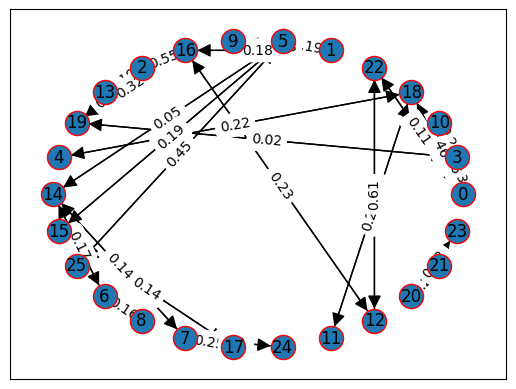

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_trajectories_static(
    energies,
    ret_pos=False,
    pos=None,
    ax=None,
    save=False,
    save_name="test.png",
):
    """
    given a list of trajectories, plot the state of at time_to_plot as a graph
    """
    # make matrix whether there is a rate connecting two states
    G = nx.DiGraph()

    
    for i in range(len(energies)):
        for j in range(len(energies)):
            if energies[i][j] > 0:
                """G.add_weighted_edges_from(
                    [(i, j, energies[i][j])], label=round(energies[i][j], 2)
                )"""
                G.add_edge(i, j, label=round(energies[i][j], 2), weight=1/energies[i][j])
                


    if pos is None:
        pos = nx.spring_layout(G)
        pos = nx.kamada_kawai_layout(G)
        pos = nx.spectral_layout(G)
        pos = nx.circular_layout(G)

    if ax != None:
        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            cmap=plt.cm.YlOrRd,
            ax=ax,
        )
        # Set edge color to red
        nodes.set_edgecolor("r")
        nx.draw_networkx_edges(G, pos, arrowstyle="-|>", arrowsize=20, ax=ax)
        # Uncomment this if you want your labels
        nx.draw_networkx_labels(G, pos, ax=ax)
        # edge labels
        nx.draw_networkx_edge_labels(
            G, pos, edge_labels=nx.get_edge_attributes(G, "label"), ax=ax
        )
    else:
        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            cmap=plt.cm.YlOrRd,
        )
        # Set edge color to red
        nodes.set_edgecolor("r")
        nx.draw_networkx_edges(
            G,
            pos,
            arrowstyle="-|>",
            arrowsize=20,
        )
        # Uncomment this if you want your labels
        nx.draw_networkx_labels(G, pos, ax=ax)
        # edge labels
        nx.draw_networkx_edge_labels(
            G,
            pos,
            edge_labels=nx.get_edge_attributes(G, "label"),
        )

    plt.show()
    if ret_pos:
        return pos
    return G
G = graph_trajectories_static(energies_mat)

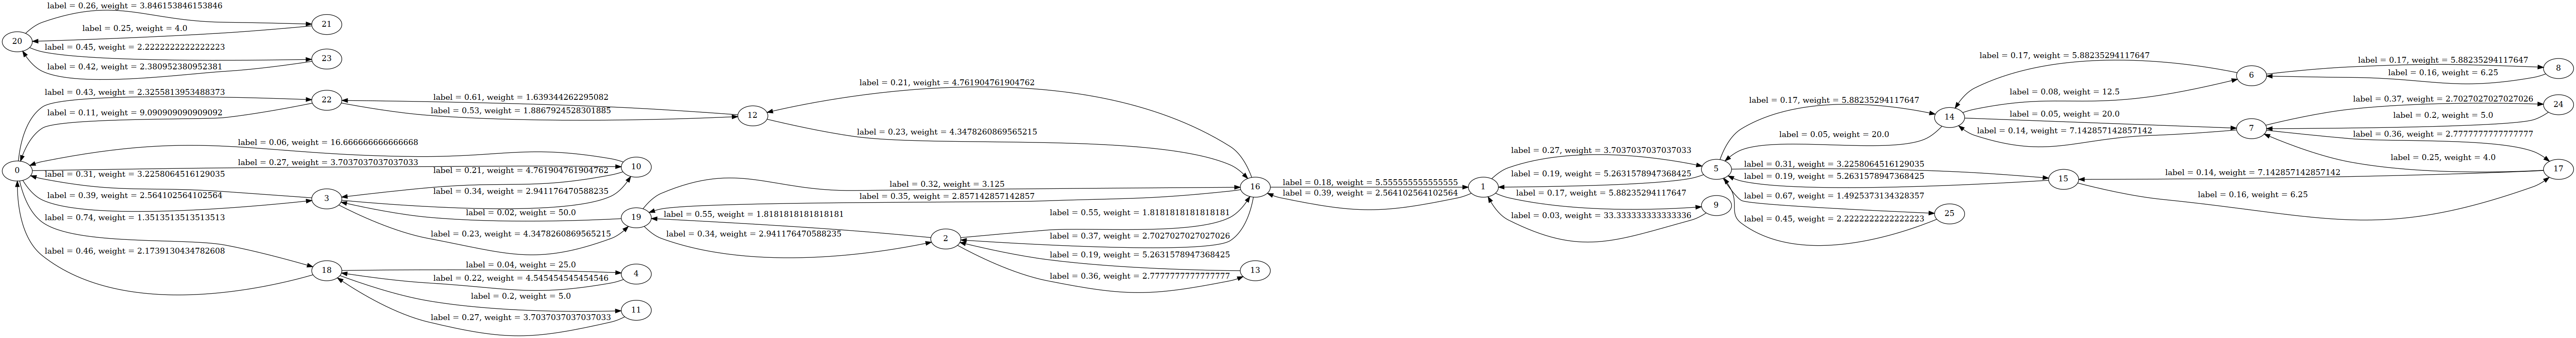

In [102]:
import pygraphviz as pgv
from IPython.display import Image, Markdown, display
def visualise(graph,hide=False,clusters=None,circular=False):
    layout = "circo" if circular else "dot"
    oneblock = True if circular else False
    G = pgv.AGraph(strict=False, directed=graph.is_directed(),
                    rankdir="LR",newrank="True",layout=layout,oneblock=oneblock)

    targetGraph = {}

    if clusters is not None:
        for (label,cluster) in clusters:
            name = "cluster_%s" % label.lower().replace(" ","_")
            subgraph = G.add_subgraph(name=name,label=label,labelloc="b",rank="same")
            for node in cluster:
                targetGraph[node] = subgraph
    else:
        for n in graph.nodes():
            targetGraph[n] = G

    for (n,data) in graph.nodes(data=True):
        label = "%s " % n
        for attribute,value in data.items():
            if not hide:
                label +=  "\n%s = " % attribute
            label += "\n%s," % value
        if len(label) > 1:
            label = label[0:-1]
        targetGraph[n].add_node(n,label=label)
    for (u,v,data) in graph.edges(data=True):

        dir = 'forward' if graph.is_directed() else 'none'
        label = ""
        for attribute,value in data.items():
            if not hide:
                label +=  " %s = " % attribute
            label += "%s," % value
        if len(label) > 1:
            label = label[0:-1]
        G.add_edge(u,v,dir=dir,label=label)
        G.layout(prog="dot")
    display(Image(G.draw(format='png')))
    return


visualise(G)

[9980, 19, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
initialization populations
{0: 405, 1: 410, 2: 382, 3: 373, 4: 396, 5: 356, 6: 374, 7: 382, 8: 387, 9: 369, 10: 382, 11: 383, 12: 377, 13: 370, 14: 388, 15: 411, 16: 370, 17: 396, 18: 386, 19: 395, 20: 394, 21: 392, 22: 380, 23: 357, 24: 407, 25: 378}
[405, 410, 382, 373, 396, 356, 374, 382, 387, 369, 382, 383, 377, 370, 388, 411, 370, 396, 386, 395, 394, 392, 380, 357, 407, 378]
initialization populations
{0: 405, 1: 410, 2: 382, 3: 373, 4: 396, 5: 356, 6: 374, 7: 382, 8: 387, 9: 369, 10: 382, 11: 383, 12: 377, 13: 370, 14: 388, 15: 411, 16: 370, 17: 396, 18: 386, 19: 395, 20: 394, 21: 392, 22: 380, 23: 357, 24: 407, 25: 378}


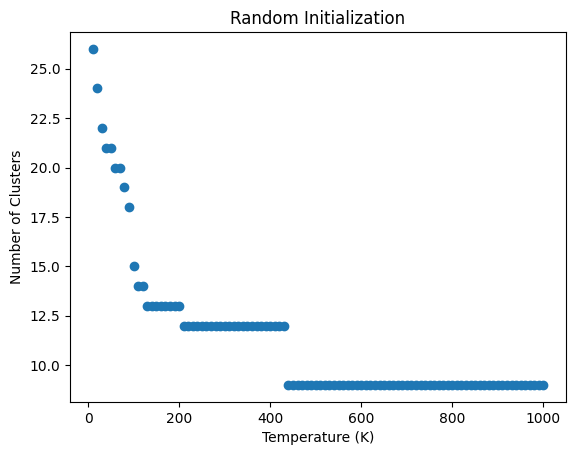

4


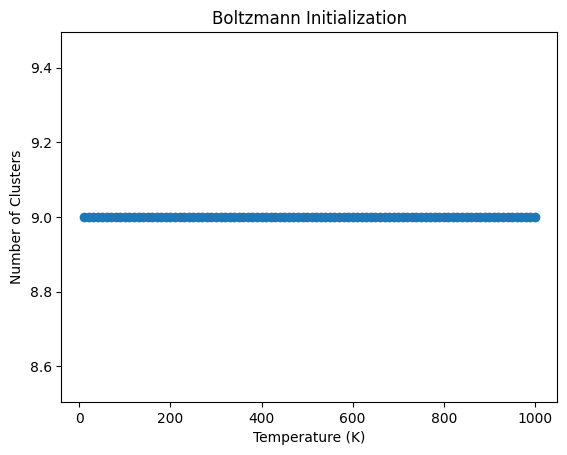

4


In [112]:
from sklearn.cluster import AffinityPropagation
import statistics as st

kb = 8.617 * 10 ** (-5)
init_boltz = boltz(energies=H1_E, T=temp_boltz, size=10000)
init_random = random_init(10000, energies_mat.shape[0])
print(init_boltz.get_init_populations())
print(init_random.get_init_populations())

def energy_to_log_rates_reciprocal(energies, temp, scale=1000): 
    """
    convert energies to rates
    """
    rates = np.zeros(energies.shape)
    for i in range(len(energies)):
        for j in range(len(energies)):
            if energies[i][j]  != 0:
                #rates[i][j] = scale * energies[i][j] / (kb * temp)
                rates[i][j] = (temp * kb / (4.1357 * 10**-15)) * np.exp(-energies[i][j] / (kb * temp))
                
    return rates


def temp_sweep_and_plot(energies_mat, min_temp=10, max_temp=1000, num_temps=100, pref = None, title=None):
    list_clusters = []
    list_temps = []
    top_cluster_list = []
    
    for temp in np.linspace(min_temp, max_temp, num_temps):
        rate_mat = energy_to_log_rates_reciprocal(energies_mat, temp, scale=1)
        #affinity_mat = dist_to_affinity(rate_mat)
        ap = AffinityPropagation(affinity='precomputed', 
                                 max_iter=10000,
                                 preference=pref).fit(rate_mat)
        n_clusters = ap.cluster_centers_indices_
        n_top_cluster = st.mode(ap.labels_)
        top_cluster = len(np.where(ap.labels_ == n_top_cluster)[0])
        list_clusters.append(len(n_clusters))
        list_temps.append(temp)
        top_cluster_list.append(top_cluster)
        #print(n_clusters)
        #print(n_clu)
    
    plt.scatter(x=list_temps, y=list_clusters)
    #plt.scatter(x=list_temps, y=top_cluster_list)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Number of Clusters")
    if title is not None:
        plt.title(title)
    else:
        plt.title("Number of Clusters vs Temperature")
    plt.show()
    #print(ap.labels_)
    # compute the number of indices in top cluster
    # get the most common index 
    #np.mode(ap.labels_)
    n_top_cluster = st.mode(ap.labels_)
    print(len(np.where(ap.labels_ == n_top_cluster)[0]))

temp_sweep_and_plot(energies_mat, pref=init_random.get_init_populations(), title="Random Initialization")
temp_sweep_and_plot(energies_mat, pref=init_boltz.get_init_populations(), title="Boltzmann Initialization")
